In [176]:
# Importing libraries needed for the project
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import numpy as np
import seaborn as sns
from sklearn import decomposition
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

In [83]:
data=pd.read_csv("/home/kasia/data_ML/ML_data.csv")

In [84]:
data = data.set_index("id")

data["diagnosis_binary"] = data["diagnosis"]
data["diagnosis_binary"] = data["diagnosis_binary"].replace("B", 0)
data["diagnosis_binary"] = data["diagnosis_binary"].replace("M", 1)
data_ML = data.drop("diagnosis", axis=1)

/tmp/ipykernel_56701/2161451360.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["diagnosis_binary"]=data["diagnosis_binary"].replace("M",1)


In [85]:
# Select columns with mean
X = data_ML.iloc[:, 0:10]
Y = data_ML["diagnosis_binary"]

In [86]:
Y.value_counts()
# there is a class imbalance in the data - more classified as 0 than 1
# to correct for class imbalance SMOTE is used
smote = SMOTE(random_state=42, sampling_strategy="minority")
X_res, Y_res = smote.fit_resample(X, Y)

In [87]:
# Splitting the data into the training and testing datasets, by default test is 25% of the data
X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res, random_state=42)

/home/kasia/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kasia/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


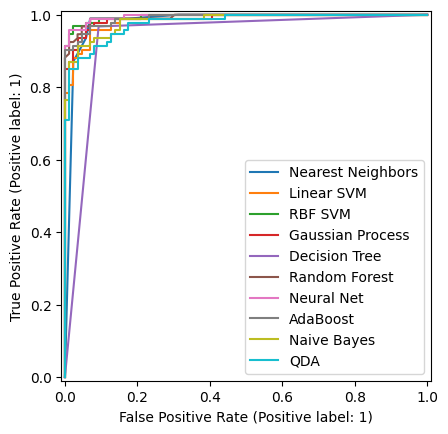

In [88]:
# Comparing ML classifiers for their potential to predict the class based on the features
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear", random_state=42),
    SVC(kernel="rbf", random_state=42),
    GaussianProcessClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    MLPClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]
ax = plt.gca()
scores = {"Accuracy": [], "Precision": [], "Recall": [], "F1": []}
ROC = {}
for classifier in classifiers:
    pipe = make_pipeline(StandardScaler(), classifier)
    pipe.fit(X_train, Y_train)
    prediction = pipe.predict(X_test)
    scores["Accuracy"].append(accuracy_score(prediction, Y_test))
    scores["F1"].append(f1_score(prediction, Y_test))
    scores["Recall"].append(recall_score(prediction, Y_test))
    scores["Precision"].append(precision_score(prediction, Y_test))
    RocCurveDisplay.from_estimator(pipe, X_test, Y_test, ax=ax)
ax.legend(names)

In [89]:
comparison = pd.DataFrame(scores)
comparison["Models"] = names
comparison = comparison.set_index("Models")

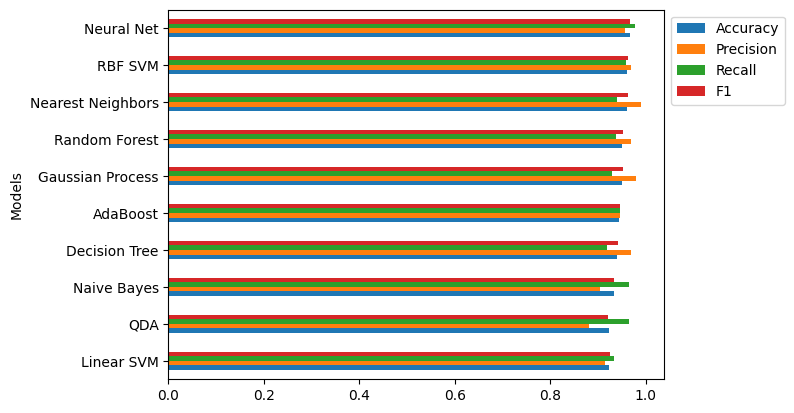

In [90]:
sorted = comparison.sort_values(by="Accuracy", ascending=True)
ax = sorted.plot.barh()
ax.legend(bbox_to_anchor=(1, 1))

In [91]:
# Hyperparameter tuning for the top model
params = {
    "mlpclassifier__activation": ["identity", "logistic", "tanh", "relu"],
    "mlpclassifier__solver": ["lbfgs", "sgd", "adam"],
    "mlpclassifier__alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "mlpclassifier__learning_rate": ["constant", "invscaling", "adaptive"],
    "mlpclassifier__learning_rate_init": [0.001, 0.01, 0.1, 1],
}
pipe = make_pipeline(StandardScaler(), MLPClassifier(random_state=42))
clf = GridSearchCV(pipe, param_grid=params, scoring="accuracy")
clf.fit(X_res, Y_res)
clf.best_params_

# This analysis indicated the best parameters and hence these are applied in the next steps for feature importance

/home/kasia/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kasia/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kasia/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kasia/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kasia/.local/lib/python3.10/site-packages/skle

{'mlpclassifier__activation': 'relu',
 'mlpclassifier__alpha': 0.1,
 'mlpclassifier__learning_rate': 'constant',
 'mlpclassifier__learning_rate_init': 1,
 'mlpclassifier__solver': 'sgd'}

In [92]:
pipe = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        random_state=42,
        activation="relu",
        alpha=0.1,
        learning_rate="constant",
        learning_rate_init=1,
        solver="sgd",
    ),
)
pipe.fit(X_train, Y_train)
importances = permutation_importance(pipe, X_train, Y_train, random_state=42)
df_importances = pd.DataFrame(importances.importances.T)
df_importances.columns = X.columns

[Text(1, 0, 'radius_mean'),
 Text(2, 0, 'texture_mean'),
 Text(3, 0, 'perimeter_mean'),
 Text(4, 0, 'area_mean'),
 Text(5, 0, 'smoothness_mean'),
 Text(6, 0, 'compactness_mean'),
 Text(7, 0, 'concavity_mean'),
 Text(8, 0, 'concave points_mean'),
 Text(9, 0, 'symmetry_mean'),
 Text(10, 0, 'fractal_dimension_mean')]

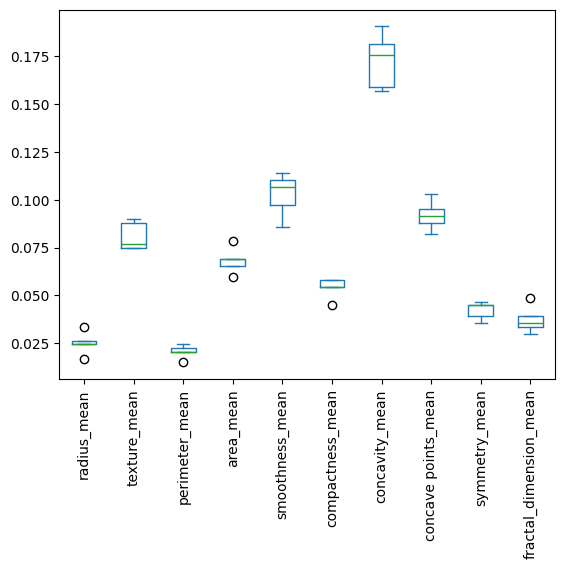

In [93]:
ax = df_importances.plot.box()
ax.set_xticklabels(df_importances.columns, rotation=90)

In [94]:
# Overall the model performs very well but the feature permutation importance seems to be very low
# This could stem from multicolinearity
# Thus calculate correlation matrix and then plot as heatmap to see what is happening
corr_matrix = X.corr()

<Axes: >

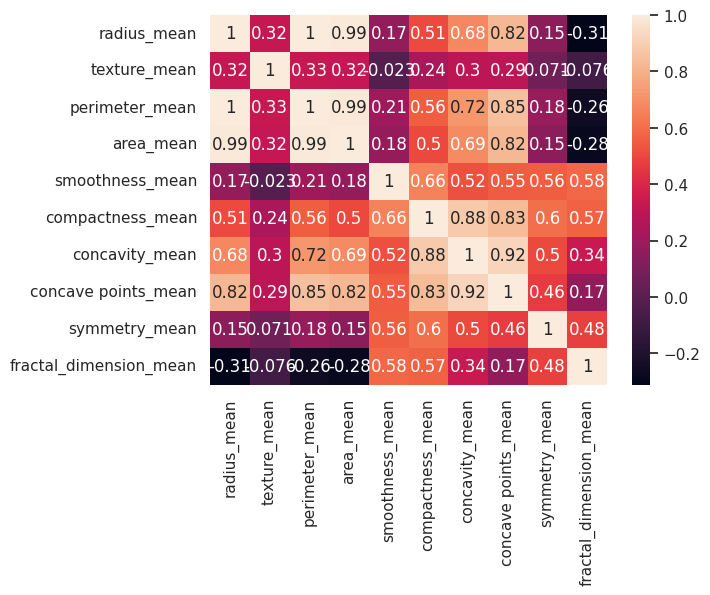

In [232]:
sns.heatmap(corr_matrix, annot=True)

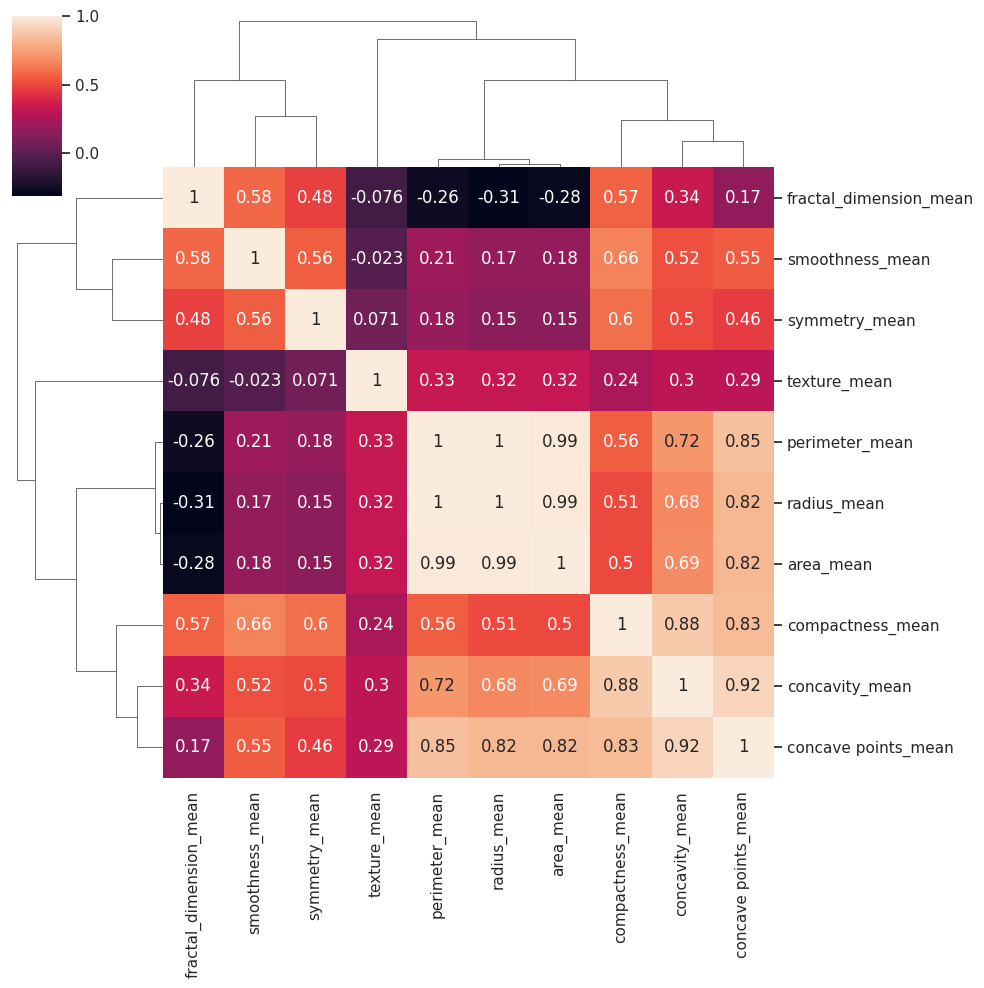

In [233]:
sns.clustermap(corr_matrix, annot=True)

In [97]:
# There were two groups of features that were very highly correlateed:
# Group 1: Perimeter, radius, area - from this group only area was kept in the further analysis
# Group 2: Concativtiy mean, concave points mean and compactness mean - concavity mean was kept as it was an important feature

X_filtered = X.loc[
    :,
    [
        "texture_mean",
        "area_mean",
        "smoothness_mean",
        "concavity_mean",
        "symmetry_mean",
        "fractal_dimension_mean",
    ],
]

In [98]:
X_filtered, Y_filtered = smote.fit_resample(X_filtered, Y)

In [99]:
# Splitting the data into the training and testing datasets, by default test is 25% of the data
X_train_f, X_test_f, Y_train_f, Y_test_f = train_test_split(
    X_filtered, Y_filtered, random_state=42
)

/home/kasia/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kasia/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


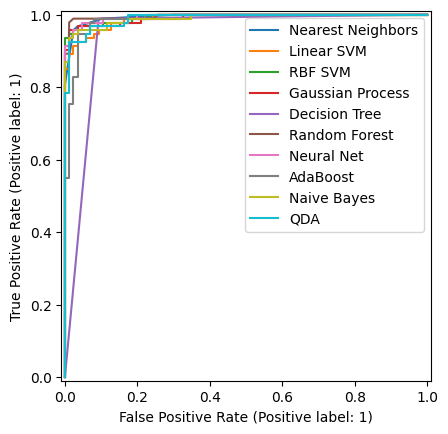

In [100]:
# Comparing ML classifiers for their potential to predict the class based on the features
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear", random_state=42),
    SVC(kernel="rbf", random_state=42),
    GaussianProcessClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    MLPClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]
ax = plt.gca()
scores_f = {"Accuracy": [], "Precision": [], "Recall": [], "F1": []}

for classifier in classifiers:
    pipe = make_pipeline(StandardScaler(), classifier)
    pipe.fit(X_train_f, Y_train_f)
    prediction_f = pipe.predict(X_test_f)
    scores_f["Accuracy"].append(accuracy_score(prediction_f, Y_test_f))
    scores_f["F1"].append(f1_score(prediction_f, Y_test_f))
    scores_f["Recall"].append(recall_score(prediction_f, Y_test_f))
    scores_f["Precision"].append(precision_score(prediction_f, Y_test_f))
    RocCurveDisplay.from_estimator(pipe, X_test_f, Y_test_f, ax=ax)
ax.legend(names)

In [101]:
scores_f = pd.DataFrame(scores_f)
scores_f.index = names
sorted_scores_f = scores_f.sort_values(by="Accuracy", ascending=True)

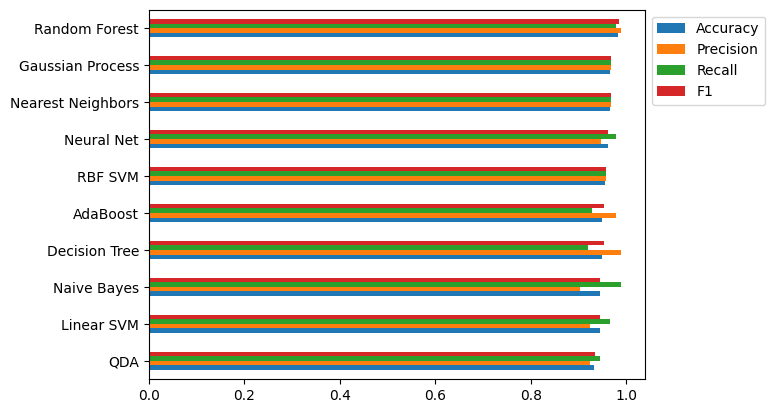

In [102]:
ax = sorted_scores_f.plot.barh()
ax.legend(bbox_to_anchor=(1, 1))

In [107]:
# After limiting the number of features Random Forest seems to be better classifier
# The hyperparameters of this classifier are here further tuned
params = {
    "randomforestclassifier__bootstrap": [True, False],
    "randomforestclassifier__criterion": ["gini", "entropy", "log_loss"],
    "randomforestclassifier__min_samples_split": [1, 2, 3, 4, 5],
    "randomforestclassifier__min_samples_leaf": [1, 2, 3],
    "randomforestclassifier__max_features": ["sqrt", "log2", None],
}
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
clf = GridSearchCV(pipe, param_grid=params, scoring="accuracy")
clf.fit(X_filtered, Y_filtered)
clf.best_params_

/home/kasia/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
270 fits failed out of a total of 1350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kasia/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kasia/.local/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/kasia/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params

{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 4}

In [108]:
pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        random_state=42,
        bootstrap=False,
        criterion="entropy",
        max_features="sqrt",
        min_samples_leaf=1,
        min_samples_split=4,
    ),
)
pipe.fit(X_train_f, Y_train_f)
prediction = pipe.predict(X_test_f)
accuracy_score(prediction, Y_test_f)

0.9888268156424581

In [109]:
importance_f = permutation_importance(pipe, X_train_f, Y_train_f, random_state=42)
importances_f_df = pd.DataFrame(importance_f["importances"].T)
importances_f_df.columns = X_train_f.columns

[Text(1, 0, 'texture_mean'),
 Text(2, 0, 'area_mean'),
 Text(3, 0, 'smoothness_mean'),
 Text(4, 0, 'concavity_mean'),
 Text(5, 0, 'symmetry_mean'),
 Text(6, 0, 'fractal_dimension_mean')]

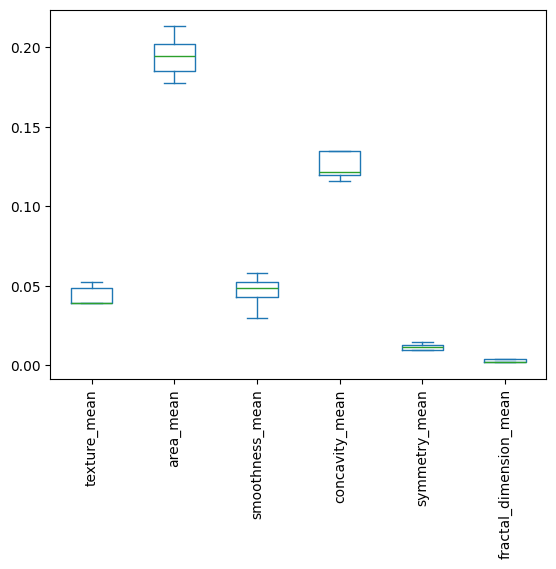

In [110]:
ax = importances_f_df.plot.box()
ax.set_xticklabels(list(importances_f_df.columns), rotation=90)
# After removing correlating features and rerunning feature importances, mean area and concavity mean appeared to be the most important features classifying breast cancer

In [132]:
diagnosis = Y_filtered
for i in range(len(diagnosis)):
    if diagnosis[i] == 0:
        diagnosis[i] = "Benign"
    elif diagnosis[i] == 1:
        diagnosis[i] = "Malignant"

data_for_pca = X_filtered
data_for_pca.index = diagnosis

In [148]:
# running pca on the filtered data
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(data_for_pca)
pca = decomposition.PCA(n_components=2)
pca_features = pca.fit_transform(scaled_df)

In [157]:
# creating dataframe with PC1 and PC2 - needed for plotting and later for classifier performance comparison plot
pca_df = pd.DataFrame(data=pca_features, columns=["PC1", "PC2"])
pca_df.index = diagnosis
pca_df["diagnosis"] = pca_df.index

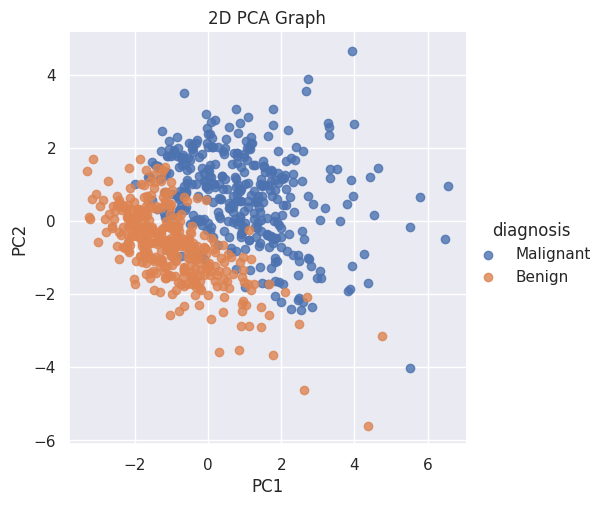

In [162]:
# Plotting PCA
sns.lmplot(x="PC1", y="PC2", data=pca_df, hue="diagnosis", fit_reg=False, legend=True)

plt.title("2D PCA Graph")
plt.show()

In [173]:
# Converting data to the format that can be used for plotting of the visual classifier comparison
X_pca_df = pca_df.loc[:, ["PC1", "PC2"]]
Y_pca_df = pd.DataFrame(pca_df.index)
Y_pca_df = Y_pca_df.replace("Malignant", 1)
Y_pca_df = Y_pca_df.replace("Benign", 0)
Y_pca_df.iloc[:, 0].to_numpy()

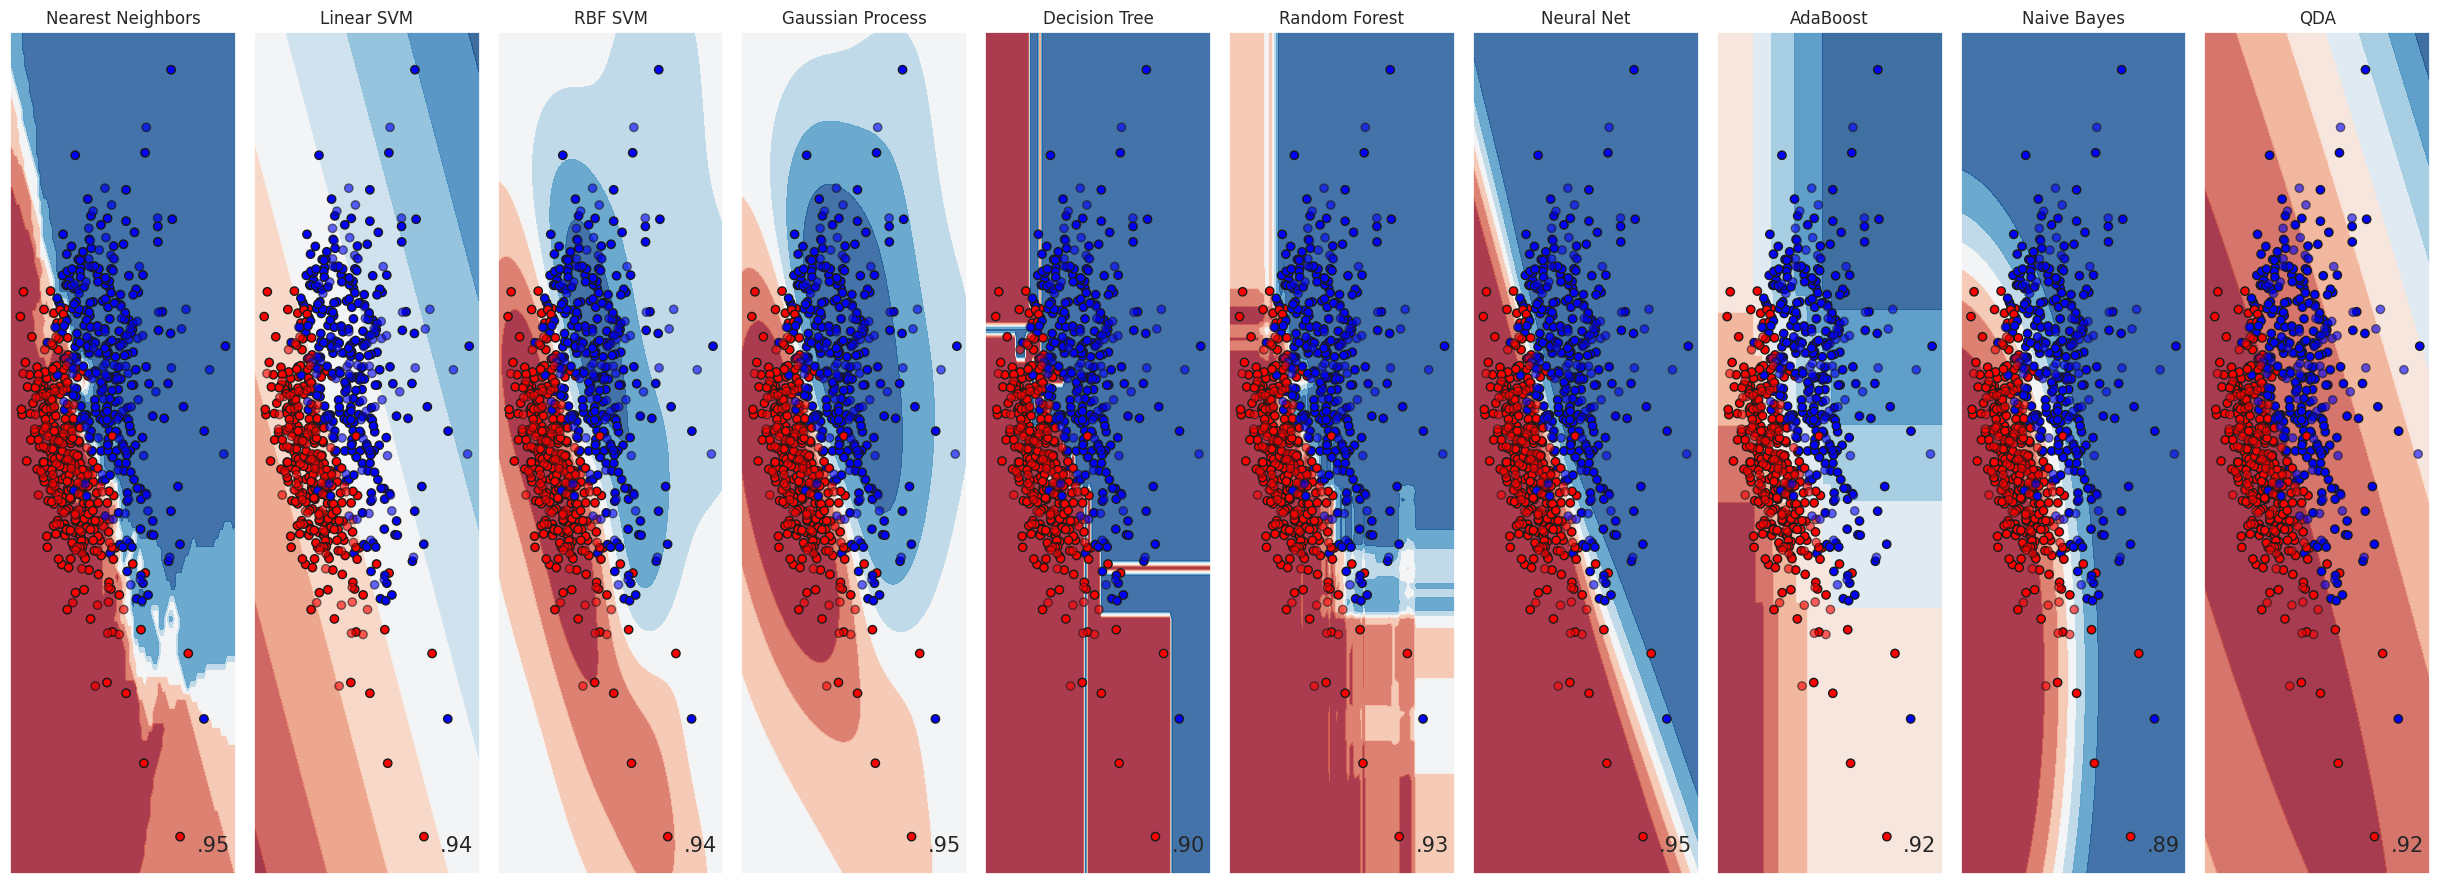

In [231]:
# Visual classifier comparison
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear", random_state=42),
    SVC(kernel="rbf", random_state=42),
    GaussianProcessClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    MLPClassifier(random_state=42),
    AdaBoostClassifier(random_state=42, algorithm="SAMME"),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

figure = plt.figure(figsize=(27, 9))

# preprocess dataset, split into training and test part

X, y = X_pca_df, Y_pca_df.iloc[:, 0].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# {lot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = plt.subplot(1, len(classifiers) + 1, 1)
ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
# Plot the testing points
ax.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

i = 1
# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=y_test,
        cmap=cm_bright,
        edgecolors="k",
        alpha=0.6,
    )

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(
        x_max - 0.3,
        y_min + 0.3,
        ("%.2f" % score).lstrip("0"),
        size=15,
        horizontalalignment="right",
    )
    i += 1

plt.tight_layout()
plt.show()